# HDR encoding standards

There are many, many of them. 
* RGBE (or Radiance HDR) (32bits) tries to cover to wide dynamic range (76 orders of magnitudes!), resulting in relatively large step size (1%) 
* XYZE iterates on RGBE, similar in dynamic range and step size, but better. 
* LogLuv 32 (32 bits) is a reasonable format. overs 38 orders  of magnitudes at 0.3% step size.
* EXT (48 bits) is expensive, but boasts top of the line performance. (covers 10.7 mag at 0.1% step size)


Maybe it's not too important because I will anyways use astronomical .fits files.  
That also means that I will have to **re-define the luminance** in astronomical images. 

In [91]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt 

import imageio
from skimage import io
imageio.plugins.freeimage.download()

In [11]:
wdir = "../../bf_data/"
img = imageio.imread(wdir+"memorial.exr")#, format='hdr-fi')

In [12]:
fn = 'Mantiuk'
tmo = cv.createTonemap(2.2)
mapped = tmo.process(img)
im2_8bit = np.clip(mapped * 255, 0, 255).astype('uint8')
cv.imwrite(wdir+fn+".png", im2_8bit)

#plt.imshow(mapped)

True

# Luminance, lightness and brightness

## Lightness
Lightness is the **Perceptual** dimension that runs from black, through gray to white. 
This is the **perceived** reflectance. That is, different from the genuine reflectance of the material.  
For example, 'black' material in sunlit can reflect more light than 'white' material under shadow. Still we call the former *black* and the later *white*.  
Lightness depends strongly on the *context*. 


## Brightness = percieved luminance
Brightness is, again, the **perceptual** dimension that runs from dim to bright. 
This is the **perceived** ***luminance***, where luminance means the *intensity* of light coming from an object.  (the SI unit for luminance is cd/m$^2$)  
Note that the *reflectance* is an inherit property of a material, whereas the *luminance* depends on the intensity of light coming to the material, and so on and so forth. 


## luminance from RGB colors
### sRGB gamma encoding 
linear combination of R,G and B components (color primaries) in sRGB color space results in non-linear brightness curve. **Gamma encoding** is applied to combinations of color primaries so that perceived brightness level is as smooth as possible for the given number of discrete colors. 
In other words, gamma encoding (others call 'correction') makes difference between brightness 5 to 6 feel similar to 250 to 251. (see also, https://stackoverflow.com/a/56678483/4294919)

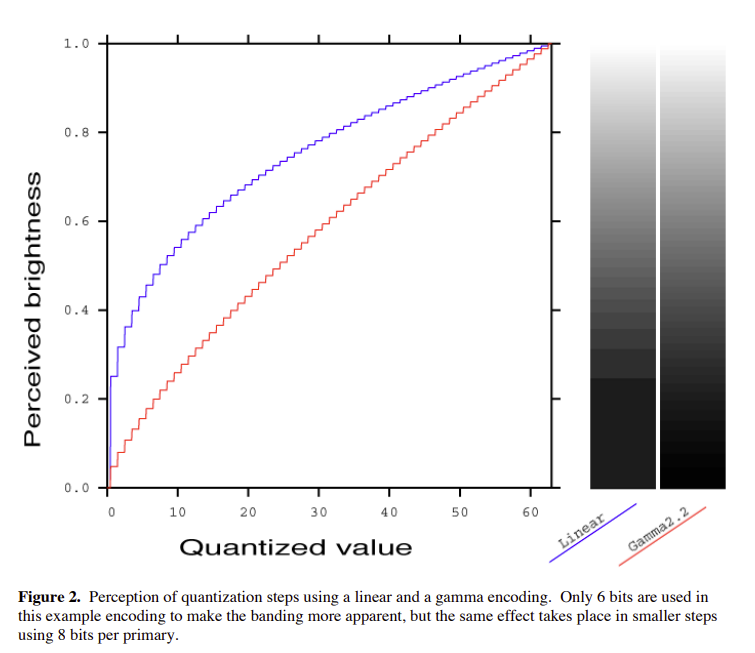
(image from http://www.anyhere.com/gward/hdrenc/hdr_encodings.html)

#### [CIE XYZ](https://en.wikipedia.org/wiki/CIE_1931_color_space#Meaning_of_X,_Y_and_Z) color space
Roughly speaking, CIE XYZ is designed to mimic the way human visual receptors function. Y is equivalent with **luminance**, Z is quasi-equal to blue, or the S cone response, and X is a mix of response curves. An XZ plane at any Y contains *all possible* chromaticities at the luminance Y. CIE XYZ color space is device-invariant, and serves as a standard reference against which other color spaces are defined.   
Since we are concerned about luminance, **CIE Y** value is also important in tone mapping. 

#### Transformation from sRGB to CIE XYZ

,
where linear R(,G,B) is inverse_gamma_correct(R) 

In [5]:
def inv_gamma(color):
    """
    Inverse of sRGB gamma encoding. 
    The gamma curve is often dubbed as power of 2.2 curve,
    but the exact form (to avoid numerical error at the lower end) is linear + power or 2.4.
    """
    conditions=[color <= 0.04045,
                color > 0.04045]
    functions=[lambda color: color/12.92,
              lambda color: ((color+0.055)/1.055)**2.4]
    return np.piecewisec(color, conditions, functions)

def rgb_to_CIEXYZ(rgb):
    transform = np.array([[0.41239080, 0.35758434, 0.18048079],
                          [0.21263901, 0.71516868, 0.07219232],
                          [0.01933082, 0.11919478, 0.95053215]])
    return np.matmul(np.asarray(rgb), transform.T)

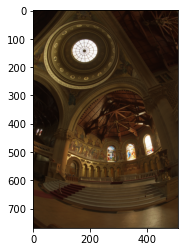

In [100]:
def simple_reinhard(img_old):
    img = img_old.copy()
    for i in range(3):
        img[:,:,i] = img_old[:,:,i] #/ img_old[:,:,i].max()
        img[:,:,i] /= (1+img[:,:,i])
    return img

mapped = simple_reinhard(img)
#mapped = img
#im2_8bit = np.clip(mapped * 255, 0, 255).astype('uint8')
#cv.imwrite(wdir+"simpleReinhard.png", im2_8bit)

(768, 512, 3)


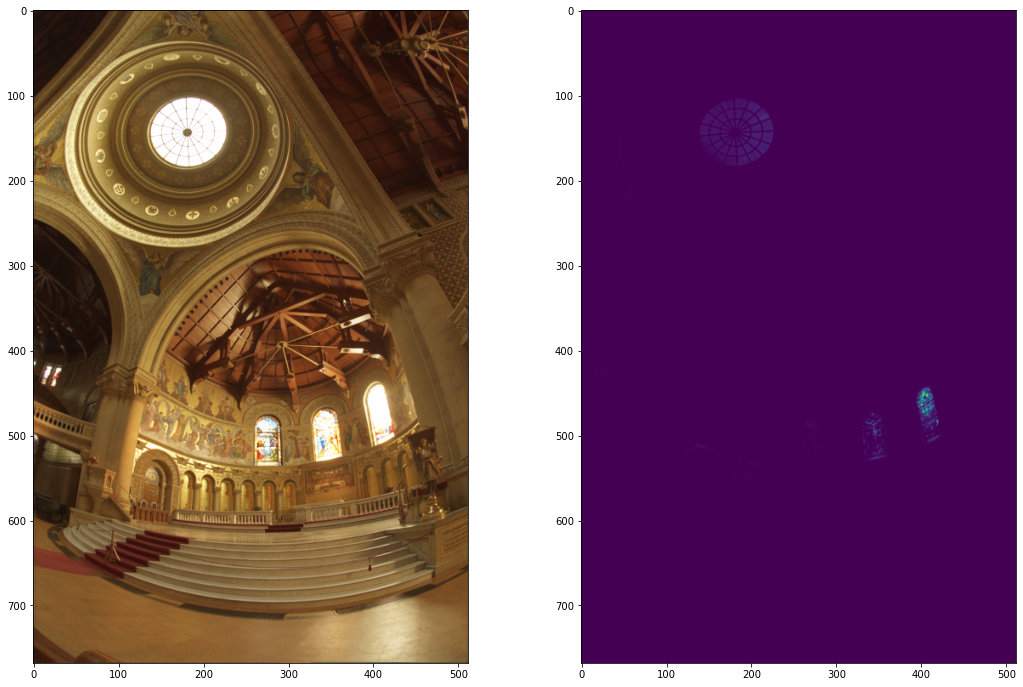

In [120]:
CIE_XYZ = rgb_to_CIEXYZ(img) # No, it's not in RGB to begin with!

print(CIE_XYZ.shape)
# Luminance map
luminance = CIE_XYZ[:,:,1]
fig, axs = plt.subplots(1,2)
fig.set_size_inches(18,12)
axs[0].set_aspect("equal")
axs[0].imshow(np.sqrt(mapped)/(1+mapped)*2)
im = axs[1].imshow(luminance)
#plt.colorbar(im)
plt.show()

In [52]:
def reinhard_color(C_old):
    C = C_old / C_old.max()
    l_old = rgb_to_CIEXYZ(C)[:,:,1]
    maxwhite = np.max(l_old)
    
    return C*(1+(C/maxwhite**2)) / (1 + C)

In [63]:
mapped = reinhard_color(img)
#mapped[:,:,1],mapped[:,:,2] = mapped[:,:,2],mapped[:,:,1].copy()
print("Max of mapped", np.max(mapped, axis=(0,1)))
im2_8bit = np.clip(mapped * 35500, 0, 255).astype('uint8')
cv.imwrite(wdir+"Reinhard_extended_c.png", im2_8bit)

Max of mapped [1.2537498 0.9755334 0.5335527]


True

In [160]:
def save_image_fix_dpi(fname, data, dpi=100, cmap='inferno', origin='lower'):
    """
    save ndarray as an image with exact number of pixels.
    """
    shape=np.shape(data)[0:2][::-1]
    size = [float(i)/dpi for i in shape]
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = plt.Axes(fig,[0,0,1,1])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data, origin=origin, cmap=cmap)
    fig.savefig(fname, dpi=dpi)
    plt.close()

def change_luminance(rgb, l_out):
    l_in = rgb_to_CIEXYZ(rgb)[:,:,1] # luminance
    multiplier = np.expand_dims(l_out/l_in, -1)
    return rgb * multiplier

def reinhard_extended(img_old):
    """
    Any pixel above the 'white point' will be saturated.
    """
    img = img_old 
    l_old=rgb_to_CIEXYZ(img)[:,:,1]
    white = np.max(l_old) * 0.5
    l_new = l_old * (1+(l_old/(white**2))) / (1+l_old)
    multiplier = l_new/l_old
    save_image_fix_dpi(wdir+'multiplier.png', multiplier, origin='upper')
    return img_old * np.expand_dims(multiplier, -1)  #change_luminance(img, l_new)
    

save_image_fix_dpi(wdir+'org_plt.png', img, origin='upper')
save_image_fix_dpi(wdir+'org_clip_plt.png', np.clip(img, 0, 1), origin='upper')
mapped = reinhard_extended(img)
imageio.imwrite(wdir+"image_io2.png",mapped)
io.imsave(wdir+"image_skimage2.png",mapped)
save_image_fix_dpi(wdir+'plt2.png', mapped, origin='upper')
# Gamma ***Inverse*** correction????
gamma = 1/2.2
gamma_corrected = np.power(mapped, gamma)#np.clip(np.power(mapped / mapped.max(), gamma) * 255.0, 0, 255)
save_image_fix_dpi(wdir+'plt_gamma.png', gamma_corrected, origin='upper')

print("Max of mapped", np.max(mapped, axis=(0,1)))
im2_8bit = np.clip(mapped/mapped.max() * 255, 0, 255).astype('uint8')
cv.imwrite(wdir+"Reinhard_extended.png", im2_8bit)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Lossy conversion from float64 to uint8. Range [0.00016754638298007362, 2.958658961063857]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.00016754638298007362, 2.958658961063857]. Convert image to uint8 prior to saving to suppress this warning.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Max of mapped [2.95865896 1.05416443 2.37910638]


True

# COLOUR-HDRI

In [3]:
import colour
from colour.models import RGB_COLOURSPACES, RGB_luminance

# Reinhard & Delvin 2004

In [4]:
def tonemapping_operator_Reinhard2004(RGB,
                                      f=0,
                                      m=0.3,
                                      a=0,
                                      c=0,
                                      colourspace=RGB_COLOURSPACES['sRGB']):
    """
    Performs given *RGB* array tonemapping using *Reinhard and Devlin (2004)*
    method.

    Parameters
    ----------
    RGB : array_like
        *RGB* array to perform tonemapping onto.
    f : numeric, optional
        :math:`f`.
    m : numeric, optional
        :math:`m`.
    a : numeric, optional
        :math:`a`.
    c : numeric, optional
        :math:`c`.
    colourspace : `colour.RGB_Colourspace`, optional
        *RGB* colourspace used for internal *Luminance* computation.

    Returns
    -------
    ndarray
        Tonemapped *RGB* array.

    References
    ----------
    :cite:`Reinhard2005c`

    Examples
    --------
    >>> tonemapping_operator_Reinhard2004(np.array(
    ...     [[[0.48046875, 0.35156256, 0.23632812],
    ...       [1.39843753, 0.55468757, 0.39062594]],
    ...      [[4.40625388, 2.15625895, 1.34375372],
    ...       [6.59375023, 3.43751395, 2.21875829]]]),
    ...     -10)  # doctest: +ELLIPSIS
    array([[[ 0.0216792...,  0.0159556...,  0.0107821...],
            [ 0.0605894...,  0.0249445...,  0.0176972...]],
    <BLANKLINE>
           [[ 0.1688972...,  0.0904532...,  0.0583584...],
            [ 0.2331935...,  0.1368456...,  0.0928316...]]])
    """

    RGB = as_float_array(RGB)

    C_av = np.array((np.average(RGB[..., 0]), np.average(RGB[..., 1]),
                     np.average(RGB[..., 2])))

    L = RGB_luminance(RGB, colourspace.primaries, colourspace.whitepoint)

    L_lav = log_average(L)
    L_min, L_max = np.min(L), np.max(L)

    f = np.exp(-f)

    m = (m if m > 0 else (0.3 + 0.7 * (
        (np.log(L_max) - L_lav) / (np.log(L_max) - np.log(L_min)) ** 1.4)))

    I_l = (c * RGB + (1 - c)) * L[..., np.newaxis]
    I_g = c * C_av + (1 - c) * L_lav
    I_a = a * I_l + (1 - a) * I_g

    RGB = RGB / (RGB + (f * I_a) ** m)

    return RGB

# Filmic tonemapping with Piecewise Power Curves

A Filmic TMO tries to reproduce Film contrast characteristics. 
It's a modification to the basic form power law $y = Ax^{b}$.

In [5]:
def tonemapping_operator_filmic(RGB,
                                shoulder_strength=0.22,
                                linear_strength=0.3,
                                linear_angle=0.1,
                                toe_strength=0.2,
                                toe_numerator=0.01,
                                toe_denominator=0.3,
                                exposure_bias=2,
                                linear_whitepoint=11.2):
    """
    Performs given *RGB* array tonemapping using *Habble (2010)* method.

    Parameters
    ----------
    RGB : array_like
        *RGB* array to perform tonemapping onto.
    shoulder_strength : numeric, optional
        Shoulder strength.
    linear_strength : numeric, optional
        Linear strength.
    linear_angle : numeric, optional
        Linear angle.
    toe_strength : numeric, optional
        Toe strength.
    toe_numerator : numeric, optional
        Toe numerator.
    toe_denominator : numeric, optional
        Toe denominator.
    exposure_bias : numeric, optional
        Exposure bias.
    linear_whitepoint : numeric, optional
        Linear whitepoint.

    Returns
    -------
    ndarray
        Tonemapped *RGB* array.

    References
    ----------
    :cite:`Habble2010d`, :cite:`Habble2010e`

    Examples
    --------
    >>> tonemapping_operator_filmic(np.array(
    ...     [[[0.48046875, 0.35156256, 0.23632812],
    ...       [1.39843753, 0.55468757, 0.39062594]],
    ...      [[4.40625388, 2.15625895, 1.34375372],
    ...       [6.59375023, 3.43751395, 2.21875829]]]))  # doctest: +ELLIPSIS
    array([[[ 0.4507954...,  0.3619673...,  0.2617269...],
            [ 0.7567191...,  0.4933310...,  0.3911730...]],
    <BLANKLINE>
           [[ 0.9725554...,  0.8557374...,  0.7465713...],
            [ 1.0158782...,  0.9382937...,  0.8615161...]]])
    """

    RGB = as_float_array(RGB)

    A = shoulder_strength
    B = linear_strength
    C = linear_angle
    D = toe_strength
    E = toe_numerator
    F = toe_denominator

    def f(x, A, B, C, D, E, F):
        return ((
            (x * (A * x + C * B) + D * E) / (x * (A * x + B) + D * F)) - E / F)

    RGB = f(RGB * exposure_bias, A, B, C, D, E, F)
    RGB = RGB * (1 / f(linear_whitepoint, A, B, C, D, E, F))

    return RGB
